In [1]:
import numpy as np
import json
import matplotlib.pyplot as plt
from matplotlib import colors
import os
#from ReadKTOutputFile import *
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#filepath = '../data_from_Christine/uniform_power_and_slope.json'
filepath = '../20200626_sierra/mega_dict.json'
with open(filepath) as infile:
    a = json.load(infile)

In [3]:
#a list of the true and reconstructed track start and end times
true_track_start_times_load = []
recon_track_start_times_load = []
true_track_end_times_load = []
recon_track_end_times_load = []
true_freq_load = []
recon_freq_load = []

for event in a.keys():
    true_track_start_times_load.append(a[event]['start_times_true'])
    recon_track_start_times_load.append(a[event]['track_start_times_recon'])
    true_track_end_times_load.append(a[event]['end_times_true'])
    recon_track_end_times_load.append(a[event]['track_end_times_recon'])
    true_freq_load.append(a[event]['start_frequencies_true'][0])
    recon_freq_load.append(a[event]['event_start_frequencies_recon'])

In [4]:
#removing events that weren't reconstructed
true_start_times = []
recon_start_times = []
true_end_times = []
recon_end_times = []
true_freq = []
recon_freq = []

for i in range(len(recon_track_end_times_load)):
    if len(recon_freq_load[i]) > 1:
        recon_freq_load[i] = [recon_freq_load[i][0]]
    if (len(recon_track_end_times_load[i]) > 0) and (len(recon_track_start_times_load[i]) > 0) and (len(recon_freq_load[i]) > 0):
        true_start_times.append(true_track_start_times_load[i])
        recon_start_times.append(recon_track_start_times_load[i])
        true_end_times.append(true_track_end_times_load[i])
        recon_end_times.append(recon_track_end_times_load[i])
        true_freq.append(true_freq_load[i])
        recon_freq.append(recon_freq_load[i])

In [5]:
#calculating the frequency error
recon_freq = np.hstack(recon_freq)
#print(len(rec_freq_list))
rec_freq = (recon_freq+24.5e9+1.4e9-50e6)
true_freq = np.asarray(true_freq)
freq_error = rec_freq/1e3 - true_freq/1e3

In [6]:
#calculating the track lengths
#converting them into arrays to make this calculation easier
true_start_times_arr = np.array([np.array(i) for i in true_start_times])
recon_start_times_arr = np.array([np.array(i) for i in recon_start_times])
true_end_times_arr = np.array([np.array(i) for i in true_end_times])
recon_end_times_arr = np.array([np.array(i) for i in recon_end_times])

true_track_lengths = true_end_times_arr - true_start_times_arr
recon_track_lengths = recon_end_times_arr - recon_start_times_arr

In [7]:
#find the min and max length
length_max_r = None
length_min_r = None
length_max_s = None
length_min_s = None
for sim, recon in zip(true_track_lengths, recon_track_lengths):
    if length_max_r == None:
        length_max_r = np.max(recon)
    elif length_max_r < np.max(recon):
        length_max_r = np.max(recon)
    
    if length_min_r == None:
        length_min_r = np.min(recon)
    elif length_min_r > np.min(recon):
        length_min_r = np.min(recon)
        
    if length_max_s == None:
        length_max_s = np.max(sim)
    elif length_max_s < np.max(sim):
        length_max_s = np.max(sim)
    
    if length_min_s == None:
        length_min_s = np.min(sim)
    elif length_min_s > np.min(sim):
        length_min_s = np.min(sim)

length_max = np.max([length_max_r, length_max_s])
length_min = np.min([length_min_r, length_min_s])
print(length_max, length_min)

0.001846454302296384 1.1153492527745876e-06


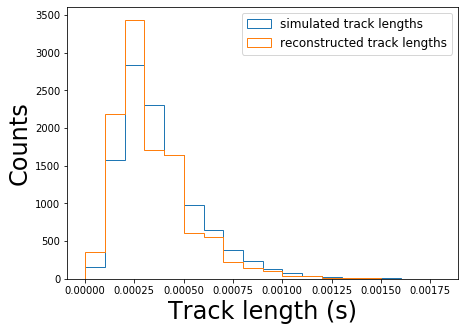

In [8]:
######################## simulation vs reconstruction plots
plt.figure(figsize=(7,5))
##total counts per track length
plt.tight_layout()
bins = np.arange(length_min, length_max, 0.0001)
#flattening the list of lists of the track lengths to make a histogram
true_lengths_flat = [length for event in true_track_lengths for length in event]
recon_lengths_flat = [length for event in recon_track_lengths for length in event]
n0, b0, p0 = plt.hist(true_lengths_flat, histtype='step', label='simulated track lengths', bins=bins)
n1, b1, p1 = plt.hist(recon_lengths_flat, histtype='step', label='reconstructed track lengths', bins=bins)
#plt.xlim(0, 1.0, 0.1)
plt.xlabel('Track length (s)', fontsize=24)
plt.ylabel('Counts', fontsize=24)
plt.legend(fontsize=12, loc=0)
#plt.savefig('../data_from_Christine/sim_v_recon_track_length_hist.png')
plt.show()

In [9]:
track_length_error_first_track = []
#freq_error_first_track = []
for i in range(len(recon_track_lengths)):
    if recon_start_times[i][0] < true_start_times[i][0]:
        track_length_error_first_track.append(recon_track_lengths[i][0]-true_track_lengths[i][0])
    else:
        for j in range(len(true_track_lengths[i])):
            try:
                if (recon_start_times[i][0] >= true_start_times[i][j]) & (recon_start_times[i][0] < true_start_times[i][j+1]):
                    track_length_error_first_track.append(recon_track_lengths[i][0]-true_track_lengths[i][j])
            #when there is no j+1 because it is iterating through the last item in true track length list
            except IndexError:
                if recon_start_times[i][0] >= true_start_times[i][j]:
                    track_length_error_first_track.append(recon_track_lengths[i][0]-true_track_lengths[i][j])
                break

In [10]:
len(track_length_error_first_track)

10768

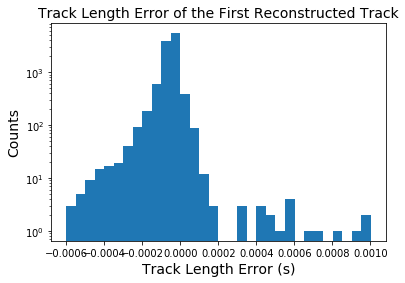

In [11]:
##### plotting a histogram of track length error
plt.figure()
plt.tight_layout()
plt.title('Track Length Error of the First Reconstructed Track', fontsize=14)
plt.hist(track_length_error_first_track, bins=np.arange(np.min(track_length_error_first_track), np.max(track_length_error_first_track), 0.00005))
plt.xlabel('Track Length Error (s)', fontsize=14)
plt.ylabel('Counts', fontsize=14)
plt.yscale('log')
#plt.savefig('../data_from_Christine/track_length_error_hist_first_track.png')
plt.show()

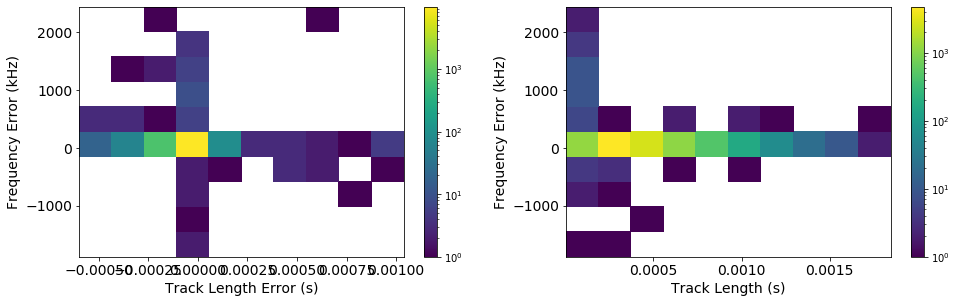

In [14]:
max_freq_error = np.max(freq_error)
min_freq_error = np.min(freq_error)
fig, ax = plt.subplots(1, 2, figsize=(16, 4.6))
#plt.tight_layout()
ax[0].set_xlabel('Track Length Error (s)', fontsize=14)
ax[0].set_ylabel('Frequency Error (kHz)', fontsize=14)
ax[0].tick_params(axis='both', labelsize=14)
hist0 = ax[0].hist2d(track_length_error_first_track, freq_error, norm=colors.LogNorm())
plt.colorbar(hist0[3], ax=ax[0])
ax[1].set_xlabel('Track Length (s)', fontsize=14)
ax[1].set_ylabel('Frequency Error (kHz)', fontsize=14)
ax[1].tick_params(axis='both', labelsize=14)
hist1 = ax[1].hist2d([track[0] for track in true_track_lengths], freq_error, norm=colors.LogNorm())
plt.colorbar(hist1[3], ax=ax[1])
#plt.grid()
#plt.savefig('../data_from_Christine/track_length_freq_error_first_track.png')
plt.show()

In [13]:
with open('../20200626_sierra/track_length.json', 'w') as length_file:
    json.dump([track[0] for track in true_track_lengths], length_file)
    
with open('../20200626_sierra/track_length_error.json', 'w') as length_error_file:
    json.dump(track_length_error_first_track, length_error_file)